# MNIST Digit Recognition Neural Network

This code implements a PyTorch-based Multi-Layer Perceptron (MLP) neural network for MNIST handwritten digit recognition task.

## Key Features:
- **Data Processing**: Loads and visualizes the MNIST dataset containing handwritten digit images (0-9)
- **Model Architecture**: Constructs a three-layer fully connected neural network (784→50→50→10) with ReLU activation functions
- **Training Process**: Uses Stochastic Gradient Descent (SGD) optimizer and Cross-Entropy loss function to train the model for 20 epochs
- **Performance Evaluation**: Evaluates model accuracy on test set and visualizes training loss and test accuracy trends over epochs
- **GPU Support**: Automatically detects and utilizes GPU acceleration for training process

The final model achieves approximately 95.28% accuracy on the test set, demonstrating the effectiveness of neural networks for image classification tasks.


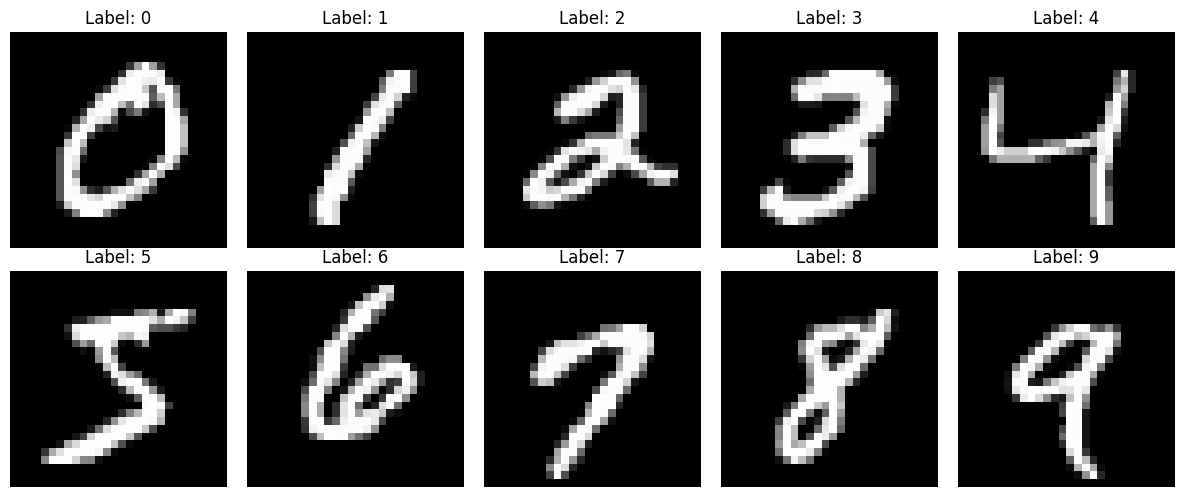

Model is on device: cuda
Epoch [1/20], Train Loss: 1.8000, Test Accuracy: 0.8108
Epoch [2/20], Train Loss: 0.5809, Test Accuracy: 0.8747
Epoch [3/20], Train Loss: 0.4116, Test Accuracy: 0.8977
Epoch [4/20], Train Loss: 0.3594, Test Accuracy: 0.9056
Epoch [5/20], Train Loss: 0.3286, Test Accuracy: 0.9131
Epoch [6/20], Train Loss: 0.3067, Test Accuracy: 0.9191
Epoch [7/20], Train Loss: 0.2887, Test Accuracy: 0.9237
Epoch [8/20], Train Loss: 0.2728, Test Accuracy: 0.9274
Epoch [9/20], Train Loss: 0.2588, Test Accuracy: 0.9283
Epoch [10/20], Train Loss: 0.2457, Test Accuracy: 0.9339
Epoch [11/20], Train Loss: 0.2339, Test Accuracy: 0.9365
Epoch [12/20], Train Loss: 0.2230, Test Accuracy: 0.9389
Epoch [13/20], Train Loss: 0.2133, Test Accuracy: 0.9412
Epoch [14/20], Train Loss: 0.2048, Test Accuracy: 0.9439
Epoch [15/20], Train Loss: 0.1965, Test Accuracy: 0.9448
Epoch [16/20], Train Loss: 0.1891, Test Accuracy: 0.9482
Epoch [17/20], Train Loss: 0.1821, Test Accuracy: 0.9472
Epoch [18/20], 

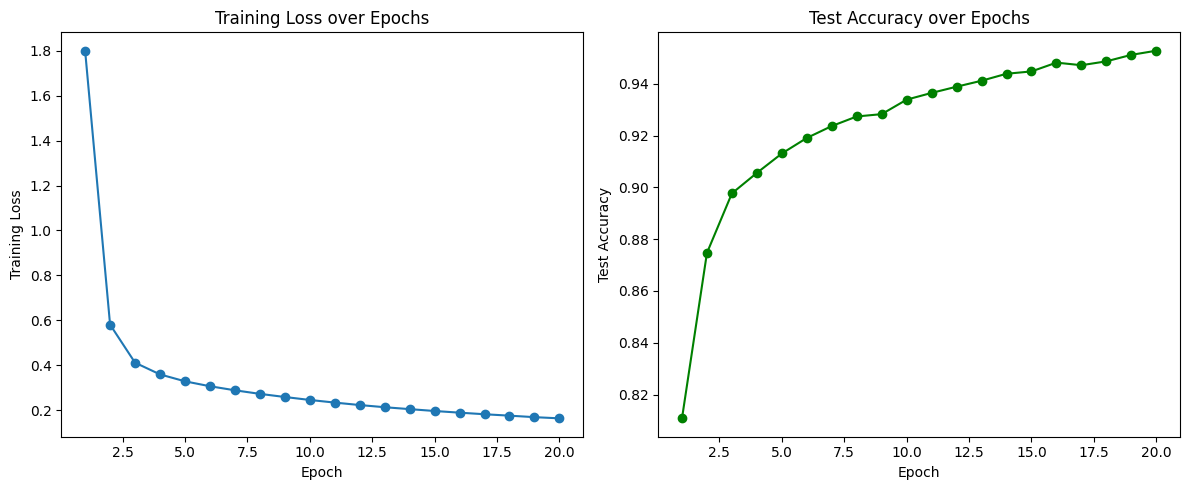

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ================================
# Create transform that converts data to tensors
# ================================
transform = transforms.ToTensor()


# ================================
# Instantiate MNIST datasets
# ================================
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# visualize
classes = list(range(10))
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()
found = {i: False for i in classes}
for img, label in train_dataset:
  if not found[label]:
    axes[label].imshow(img.squeeze(), cmap='gray')
    axes[label].set_title(f"Label: {label}")
    axes[label].axis('off')
    found[label] = True
  if all(found.values()):
    break
plt.tight_layout()
plt.show()

# ================================
# Create DataLoader
# ================================
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ================================
# Build the model
# ================================
# input size: 28x28=784，output: 10 classes
class MLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=50, output_dim=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Flatten the input tensor (batch, 1,28,28) -> (batch, 784)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP()

# ================================
# Instantiate loss function
# ================================
criterion = nn.CrossEntropyLoss()

# ================================
# Instantiate loss optimizer
# ================================
optimizer = optim.SGD(model.parameters(), lr=0.01)

# ================================
# Move the model to GPU
# ================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("Model is on device:", device)

# ================================
# Training loop
# ================================
num_epochs = 20
train_loss_history = []   # record the training loss over epoches
test_accuracy_history = []

for epoch in range(num_epochs):
  # Training
  model.train()
  running_loss = 0.0
  for images, labels in train_loader:
    # move data to GPU
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()         # zero the optimizaer
    outputs = model(images)       # forward pass
    loss = criterion(outputs, labels) # compute loss
    loss.backward()            # backward
    optimizer.step()           # optimize

    # record the loss over all batches
    running_loss += loss.item() * images.size(0) # loss * batch size

  avg_train_loss = running_loss / len(train_loader.dataset)
  train_loss_history.append(avg_train_loss)

  # Testing
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device) # move data to GPU
      outputs = model(images)                 # forward pass

      # get the highest "confident" labels as prediction
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  # track the accuracy rates
  accuracy = correct / total
  test_accuracy_history.append(accuracy)
  print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Accuracy: {accuracy:.4f}")

# ================================
# Plot training loss and test accuracy over epochs
# ================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), test_accuracy_history, marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy over Epochs")

plt.tight_layout()
plt.show()
